라이브러리 로드

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_model_summary
from model_resnet import *
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import model_urls
import torchvision_edit.models_e as models 

GPU 설정

In [2]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

데이터 로드

In [3]:
train_transform=transforms.Compose([transforms.ToTensor(),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.Normalize((0.5,),(0.5,))])

test_transform=transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,),(0.5,))])

In [4]:
trainset=datasets.FashionMNIST(root='content',
train=True,download=True,
transform=train_transform)

testset=datasets.FashionMNIST(root='content',
train=False,download=True,
transform=test_transform)

/home/ahnsunghyun/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(len(trainset))
print(len(testset))

60000
10000


In [6]:
train_loader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader=DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)

In [7]:
images,labels=next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
steps_per_epoch=len(train_loader)
print(steps_per_epoch)

469


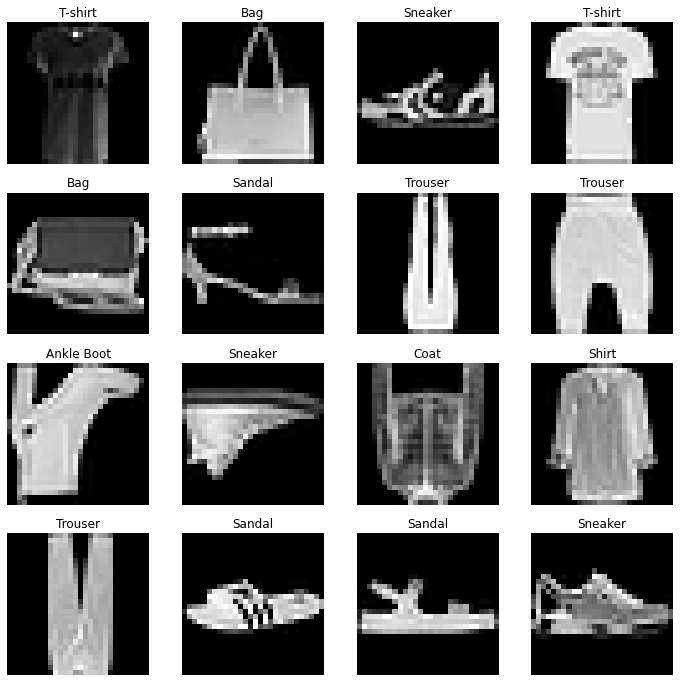

In [9]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

figure=plt.figure(figsize=(12,12))
cols,rows=4,4
for i in range(1,cols*rows+1):
    image=images[i].squeeze()
    label_idx=labels[i].item()
    label=classes[label_idx]

    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image,cmap='gray')

plt.show()

In [10]:
from torch import Tensor

In [12]:
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: Tensor) -> Tensor:
        # pytorch version >= 0.9.0
        # x = x.permute(0, 2, 3, 1)
        # x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        # x = x.permute(0, 3, 1, 2)

        # pytorch version < 0.9.0
        x = x.transpose(1,2)
        x = x.transpose(2,3)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.transpose(2,3)
        x = x.transpose(1,2)
        return x

In [13]:
model=models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# 모델 일부만 사용 
model.features=nn.Sequential(*list(model.features.children())[0:6])
model.avgpool=nn.Identity()
model.classifier=nn.Identity()

모델 확인

In [15]:
input=torch.zeros(128, 3, 28, 28)
print(pytorch_model_summary.summary(model, input, show_input=True))
print(model.parameters)

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1     [128, 3, 28, 28]           4,704           4,704
     LayerNorm2d-2      [128, 96, 7, 7]             192             192
         CNBlock-3      [128, 96, 7, 7]          79,296          79,296
         CNBlock-4      [128, 96, 7, 7]          79,296          79,296
         CNBlock-5      [128, 96, 7, 7]          79,296          79,296
     LayerNorm2d-6      [128, 96, 7, 7]             192             192
          Conv2d-7      [128, 96, 7, 7]          73,920          73,920
         CNBlock-8     [128, 192, 3, 3]         306,048         306,048
         CNBlock-9     [128, 192, 3, 3]         306,048         306,048
        CNBlock-10     [128, 192, 3, 3]         306,048         306,048
    LayerNorm2d-11     [128, 192, 3, 3]             384             384
         Conv2d-12     [128, 192, 3, 3]         295,296        

나의 모델 정의

In [21]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.upsample=nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        self.conv=nn.Conv2d(1,3,3)
        self.batchN=nn.BatchNorm2d(3)
        self.network=model
        self.layernorm=LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
        self.cbam = CBAM(384, 16) # CBAM
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(384, 384),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(384, 10)
        )
        
    def forward(self,x):
        x=self.upsample(x)
        x=F.relu(self.conv(x))
        x=self.batchN(x)
        x=self.network(x)
        x=self.max_pool(x)
        x = torch.flatten(x, 1)
        x=self.fc_layer(x)
        return x

In [22]:
mynet=MyNet()
mynet.to(device)

MyNet(
  (upsample): Upsample(scale_factor=2.0, mode=bicubic)
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchN): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (network): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU()
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
    

나의 모델 확인

In [23]:
input=torch.zeros(1,1,28,28).to(device)
print(pytorch_model_summary.summary(mynet, input, show_input=True))
print(type(mynet(input)))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
        Upsample-1      [1, 1, 28, 28]               0               0
          Conv2d-2      [1, 1, 56, 56]              30              30
     BatchNorm2d-3      [1, 3, 54, 54]               6               6
        ConvNeXt-4      [1, 3, 54, 54]      12,348,000      12,348,000
       MaxPool2d-5      [1, 384, 3, 3]               0               0
         Dropout-6            [1, 384]               0               0
          Linear-7            [1, 384]         147,840         147,840
            ReLU-8            [1, 384]               0               0
         Dropout-9            [1, 384]               0               0
         Linear-10            [1, 384]           3,850           3,850
Total params: 12,499,726
Trainable params: 12,499,726
Non-trainable params: 0
---------------------------------------------------------------------

손실함수와 옵티마이저

In [24]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mynet.parameters(), lr=0.0001, eps=1e-08)

모델 학습

In [25]:
batch_size=128 # 학습할 때 얼마나 많은 데이터를 이용할 것인가 
steps_per_epoch=len(train_loader) # 한 epoch 당 스텝 수 (batch_size크기의 데이터 개수)

# epoch 수는 50
for epoch in range(100):
    running_loss=0.0 # 초기 누적 오차 = 0 
    batch_acc_list=[] # batch 별 accuracy list

    # step (steps_per_epoch:469)
    for i, data in enumerate(train_loader,0):
        # 데이터 입력
        inputs, labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # Gradient -> 0
        optimizer.zero_grad()
        # 순전파+역전파+최적화 
        outputs=mynet(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # 누적 오차 
        running_loss +=loss.item()

        # batch_accuracy 계산 (한 스텝마다 accuracy 저장)
        _,predicted=torch.max(outputs.data,1)
        correct=(predicted==labels).sum().item()
        batch_acc = correct/batch_size * 100
        batch_acc_list.append(batch_acc)

        if i % 100 == 99:
            print('Epoch: {}, Iter: {}, Loss:{}'.format(epoch+1,i+1,running_loss/steps_per_epoch))
            running_loss=0.0

    # epoch마다 accuracy 출력
    epoch_acc=np.mean(batch_acc_list) # batch_accuracy_list의 평균으로 계산 (전체 데이터를 기준)
    print('Epoch: {}, Acc:{}'.format(epoch+1,epoch_acc))
        

Epoch: 1, Iter: 100, Loss:0.19952646634980306
Epoch: 1, Iter: 200, Loss:0.08670559569970886
Epoch: 1, Iter: 300, Loss:0.07136641944776466
Epoch: 1, Iter: 400, Loss:0.06530378797033956
Epoch: 1, Acc:84.5665644989339
Epoch: 2, Iter: 100, Loss:0.05554414643788897
Epoch: 2, Iter: 200, Loss:0.05239257422972844
Epoch: 2, Iter: 300, Loss:0.05154053345799192
Epoch: 2, Iter: 400, Loss:0.05202615788496379
Epoch: 2, Acc:91.47454690831556
Epoch: 3, Iter: 100, Loss:0.045351112924659175
Epoch: 3, Iter: 200, Loss:0.04305237075730936
Epoch: 3, Iter: 300, Loss:0.04102734806758763
Epoch: 3, Iter: 400, Loss:0.04265612600518188
Epoch: 3, Acc:92.93876599147121
Epoch: 4, Iter: 100, Loss:0.03665206922905277
Epoch: 4, Iter: 200, Loss:0.0395172423264111
Epoch: 4, Iter: 300, Loss:0.036739394561187036
Epoch: 4, Iter: 400, Loss:0.03795938467038974
Epoch: 4, Acc:93.89492270788912
Epoch: 5, Iter: 100, Loss:0.03428110483485752
Epoch: 5, Iter: 200, Loss:0.03311463213487983
Epoch: 5, Iter: 300, Loss:0.0347031623140962

모델 테스트

In [33]:
correct=0
total=0

with torch.no_grad():
    for data in test_loader:
        images, labels=data
        images=images.to(device)
        labels=labels.to(device
        )
        outputs=mynet(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(correct/total*100)

93.76
